# triangle_data_structure

> Data structure for triangulation

See https://cs184.eecs.berkeley.edu/public/sp22/lectures/lec-8-mesh-representations-and-geometr/lec-8-mesh-representations-and-geometr.pdf

None of the methods below are optimized, and on many occasions, things are linear/quadratic in the mesh size even though they need not be, because it was the easiest solution

In [ ]:
#| default_exp triangle

In [ ]:
#| hide
from nbdev.showdoc import *
import nbdev

In [ ]:
#| hide
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy import spatial

In [ ]:
#| hide

from dataclasses import dataclass
from typing import Union, Dict, List, Tuple, Iterable
from nptyping import NDArray, Int, Float, Shape

from fastcore.foundation import patch

## helper functions

In [ ]:
#| export

def removekey(d, key):
    r = dict(d)
    del r[key]
    return r

In [ ]:
#| hide
from bisect import bisect_left

In [ ]:
bisect_left([-1, 0, 1, 2], 1)

In [ ]:
#| export
def flatten(lst, max_depth=1000, iter_count=0):
    """
    Flatten a list of lists into a list.

    Also works with inhomogeneous lists, e.g., [[0,1],2]. The argument
    depth determines how "deep" to flatten the list, e.g. with max_depth=1:
    [[(1,0), (1,0)]] -> [(1,0), (1,0)].

    Parameters
    ----------
    lst : list
        list-of-lists.
    max_depth : int, optional
        To what depth to flatten the list.
    iter_count : int, optional
        Helper argument for recursion depth determination.
    Returns
    -------
    iterator
        flattened list.

    """
    for el in lst:
        if (isinstance(el, Iterable) and not isinstance(el, (str, bytes))
                and iter_count < max_depth):
            yield from flatten(el, max_depth=max_depth,
                               iter_count=iter_count+1)
        else:
            yield el

In [ ]:
#| export
def sort_vertices(vertices: np.ndarray) -> np.ndarray:
    """Sort vertices of cycle counter clockwise by polar angle. Guaranteed to work for non-convex polygons."""
    phis = [np.arctan2(*x[::-1]) for x in vertices]
    return np.stack([x for _, x in sorted(zip(phis, vertices))])

def sort_ids_by_vertices(ids: Iterable[int], vertices: Iterable[NDArray]) -> list:
    """Like sort_vertices, sort ids of cycle counter clockwise by polar angle."""
    phis = [np.arctan2(*x[::-1]) for x in vertices]
    return [x for _, x in sorted(zip(phis, ids))]

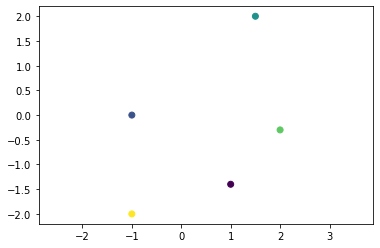

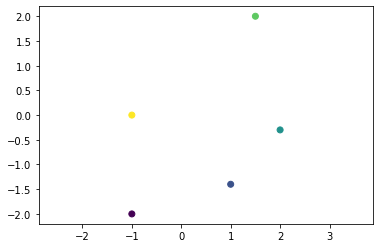

In [ ]:
pts = np.array([[1,-1.4], [-1, 0], [1.5, 2], [2, -.3], [-1, -2]])

plt.scatter(*pts.T, c=np.arange(5))
plt.axis("equal")
plt.show()

pts_sorted = sort_vertices(pts)

plt.scatter(*pts_sorted.T, c=np.arange(5))
plt.axis("equal")
plt.show()

## create some test data using scipy

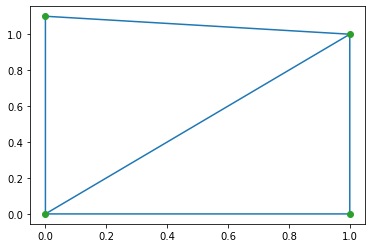

In [ ]:
points = np.array([[0, 0], [0, 1.1], [1, 0], [1, 1]])

tri = spatial.Delaunay(points)

plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')

plt.show()

In [ ]:
# attributes

tri.points, tri.simplices, tri.neighbors

(array([[0. , 0. ],
        [0. , 1.1],
        [1. , 0. ],
        [1. , 1. ]]),
 array([[2, 3, 0],
        [3, 1, 0]], dtype=int32),
 array([[ 1, -1, -1],
        [-1,  0, -1]], dtype=int32))

In [ ]:
# methods

tri.find_simplex, tri.add_points

(<bound method Delaunay.find_simplex of <scipy.spatial._qhull.Delaunay object>>,
 <bound method Delaunay.add_points of <scipy.spatial._qhull.Delaunay object>>)

## List of Pts + Triangles

Simplest data structure for a triangulation:

- Vertices = [($x_0$,$y_0$), ... ]
- Triangles = [(vertex id 1, vertex id 2, vertex id 3), ...]

From this data, one can compute the neighbor relationship of triangles
- Triangle neighbors = [(triangle id 1, triangle id 2, triangle id 3), ...]

How should we index things? We want to be able to refer to points and faces consistently over time series of meshes, so just using their index in the list is no good. We shall use dictionaries instead.

For future reference, we will make the faces oriented _counterclockwise_. This matches the convention of the `.obj` file format.

In [ ]:
#| export

def get_neighbors(faces):
    """compute neighbor list by checking which triangles share 2 vertices. Note: this is quadratic"""
    neighbors = {key: [nghb_key for nghb_key, pot_nghb in faces.items()
                   if len(set(pot_nghb)&set(face)) == 2]
             for key, face in faces.items()}
    return neighbors

class ListOfPtsAndFaces:
    def __init__(self, points, faces, neighbors=None):
        # if we pass lists, automatically assign ids to triangles and vertices
        points = points if type(points) is dict else {ix: x for ix, x in enumerate(points)}
        faces = faces if type(faces) is dict else {ix: x for ix, x in enumerate(faces)}
        # ensure that all triangles are ordered cc-wise
        faces = {key: sort_ids_by_vertices(fc, [points[x] for x in fc])
                 for key, fc in faces.items()}
        self.points, self.faces = (points, faces)
        self.neighbors = get_neighbors(faces) if neighbors is None else neighbors
        
    # some basic methods
    def remove_pt(self, pt_id):
        del self.points[pt_id]
        self.faces = {key: face for key, face in self.faces.items() if not pt_id in face}
        self.neighbors = get_neighbors(self.faces)
        
    def get_combined_edges(self):
        """Get a list of unique edges. Edges are a tuple ((vert 1, vert 2), (face 1, face 2)). Boundary edges 
        have face 1 None."""
        combined_edges = []
        for fc_key, fc in self.faces.items():
            neighbors = self.neighbors[fc_key]
            vertex_edges = [(fc+[fc[0]])[i:i+2] for i in range(len(fc))]
            for vertex_edge in vertex_edges:
                # check if it is shared with neighbor
                other_key = [nghb for nghb in neighbors if all([v in self.faces[nghb] for v in vertex_edge])]
                face_edge = sorted([fc_key, other_key[0]]) if other_key != [] else (None, fc_key)
                combined_edge = (tuple(sorted(vertex_edge)), tuple(face_edge))
                combined_edges.append(combined_edge)
        return set(combined_edges)
        
    @staticmethod
    def fromObj(fname):
        return None

In [ ]:
test_mesh = ListOfPtsAndFaces(list(tri.points), list(tri.simplices))

In [ ]:
test_mesh.faces

{0: [0, 2, 3], 1: [0, 3, 1]}

In [ ]:
test_mesh.points

{0: array([0., 0.]),
 1: array([0. , 1.1]),
 2: array([1., 0.]),
 3: array([1., 1.])}

In [ ]:
test_mesh.get_combined_edges()

{((0, 1), (None, 1)),
 ((0, 2), (None, 0)),
 ((0, 3), (0, 1)),
 ((1, 3), (None, 1)),
 ((2, 3), (None, 0))}

In [ ]:
#| export
@patch
def saveObj(self:ListOfPtsAndFaces, fname, save_ids=False):
    """save as obj file. .obj automatically appended to fname. If save_ids is True, also save a list
    of vertex and cell ids."""
    # create a sorted list of vertices
    vertex_keys = sorted(self.points.keys())
    points_list = [self.points[key] for key in vertex_keys]
    # change faces list to refer to this ordered list. Counting from 1 for .obj
    face_keys = sorted(self.faces.keys())
    faces_list = [[bisect_left(vertex_keys, v)+1 for v in self.faces[key]] for key in face_keys]
    # overwrite
    try:
        os.remove(fname+".obj")
    except OSError:
        pass
    # write
    with open(fname+".obj", "a") as f:
        f.write('# vertices')
        for pt in points_list:
            to_write = ' '.join(['v'] + [str(x) for x in pt] + ['0']) + '\n'  # include z-ccoord
            f.write(to_write)
        f.write('# faces')
        for fc in faces_list:
            to_write = ' '.join(['f'] + [str(x) for x in fc]) + '\n'
            f.write(to_write)
    if save_ids:
        try:
            os.remove(fname+"_ids.txt")
        except OSError:
            pass
        with open(fname+"_ids.txt", "a") as f:
            f.write('# vertex IDs corresponding to .obj file\n')
            for key in vertex_keys:
                f.write(str(key)+'\n')
            f.write('# face IDs corresponding to .obj file\n')
            for key in face_keys:
                f.write(str(key)+'\n')


In [ ]:
test_mesh.saveObj('test_mesh', save_ids=True)
# tested by opening in paraview, looks good

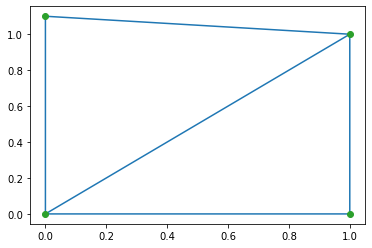

In [ ]:
test_mesh = ListOfPtsAndFaces(list(tri.points), list(tri.simplices))

print(test_mesh.faces, test_mesh.neighbors)

test_mesh.remove_pt(1)

print(test_mesh.faces, test_mesh.neighbors)

{0: array([2, 3, 0], dtype=int32), 1: array([3, 1, 0], dtype=int32)} {0: [1], 1: [0]}
{0: array([2, 3, 0], dtype=int32)} {0: []}


## Half-edge

More complicated operations (e.g. flipping triangles) are a pain to implement with this simple data structure, which furthermore does not contain edges. We now build a half-edge data structure class.

A half-edge contains the following data:
- `next` - the next half edge
- `twin` - the twin half edge
- `cell` - the cell it belongs to
- `vertices` - start and end vertex

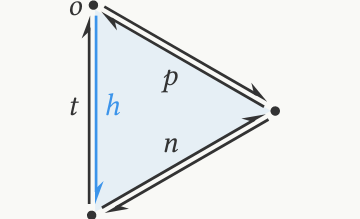
See https://jerryyin.info/geometry-processing-algorithms/half-edge/

In [ ]:
#| export

@dataclass
class HalfEdge:
    """Attribute holder class for half edges. Attributes point to other items."""
    _heid : int
    nxt: int
    twin: int
    cell: Union[int, None] # None if it's a boundary
    vertices: tuple # 0 is origin, 1 is destination
        
@dataclass
class Vertex:
    """Attribute holder class for vertices. Attributes point to other items. Note: different from the
    standard half edge data structure, I store all incident he's, for latter convenience (e.g. force balance)
    computation."""
    _vid : int
    coords : NDArray[Shape["2"], Float]
    incident : List[HalfEdge]

@dataclass
class Face:
    """Attribute holder class for faces. Attributes point to other items."""
    _fid : int
    hes : List[HalfEdge]
        
@dataclass
class Edge:
    """Attribute holder class for edges. Main point is to use it to store variables for ODE evolution"""
    _eid : int
    hes : Tuple[HalfEdge, HalfEdge]
    variables : dict
        
    def __post_init__(self):
        assert (self.hes[0].twin == self.hes[1]._heid) and (self.hes[1].twin == self.hes[0]._heid)

In [ ]:
he = HalfEdge(10031, 1, 4, 2, (2, 3))

v = Vertex(10, np.array([2.0, 2.1]), he)
he_new = HalfEdge(10034, 1, 4, 2, (2, 3))

v.incident = he_new # we can edit the incident edge
v

Vertex(_vid=10, coords=array([2. , 2.1]), incident=HalfEdge(_heid=10034, nxt=1, twin=4, cell=2, vertices=(2, 3)))

In [ ]:
v.incident == he_new, not (v.incident == he)

(True, True)

The additional data provided by the half-edge mesh structure will be very helpful further on. In order to initialize the half-edge data structure, we use the `ListOfPtsAndFaces` class from above.

TO DO: figure out how to deal with edge id's, edge variables.

Inspired by: https://github.com/yig/trimesh/blob/master/trimesh.py

The first question is how to get the half-edges from the face-list.

In [ ]:
#| export
def get_half_edges(mesh: ListOfPtsAndFaces) -> Dict[int, HalfEdge]:
    """Create list of half-edges from a ListOfPtsAndFaces mesh"""
    heid_counter = 0
    pre_hes = []
    # first create half edges without their twins by going around each face.
    for key, fc in mesh.faces.items():
        # ensure face is oriented correctly
        fc = sort_ids_by_vertices(fc, [mesh.points[x] for x in fc])
        heids = [heid_counter+i for i in range(len(fc))]
        nxts = np.roll(heids, -1).tolist()
        vertices = [tuple((fc+[fc[0]])[i:i+2]) for i in range(len(fc))]
        pre_hes += [HalfEdge(_heid, nxt, None, key, verts) for _heid, nxt, verts in zip(heids, nxts, vertices)]
        heid_counter += len(fc)
    # now match the half-edges. if they cannot match, add a new he with cell None (note: quadratic)
    edges = mesh.get_combined_edges()
    for e in edges:
        if e[1][0] is not None: # interior edge
            he1 = next(he for he in pre_hes if he.vertices == e[0])
            he2 = next(he for he in pre_hes if he.vertices == e[0][::-1])
        else: # exterior edge, add another half edge with
            he1 = next(he for he in pre_hes if tuple(sorted(he.vertices)) == e[0])
            # hardest part: find the "nxt":
            he2 = HalfEdge(heid_counter, None, he1._heid, None, he1.vertices[::-1])
            pre_hes.append(he2)
            heid_counter += 1
        he1.twin, he2.twin = (he2._heid, he1._heid)
    # find the "next" of the boundary edges. we can just traverse inshallah
    bdry = [he for he in pre_hes if he.cell is None]
    for he1 in bdry:
        try:
            nxt = next(he2 for he2 in bdry if he1.vertices[1] == he2.vertices[0])
            he1.nxt = nxt._heid
        except StopIteration:
            print("Corner detected")
            
    # turn into dict for easy access
    return {he._heid: he for he in pre_hes}

In [ ]:
hes = get_half_edges(test_mesh)
hes

{0: HalfEdge(_heid=0, nxt=1, twin=6, cell=0, vertices=(0, 2)),
 1: HalfEdge(_heid=1, nxt=2, twin=9, cell=0, vertices=(2, 3)),
 2: HalfEdge(_heid=2, nxt=0, twin=3, cell=0, vertices=(3, 0)),
 3: HalfEdge(_heid=3, nxt=4, twin=2, cell=1, vertices=(0, 3)),
 4: HalfEdge(_heid=4, nxt=5, twin=7, cell=1, vertices=(3, 1)),
 5: HalfEdge(_heid=5, nxt=3, twin=8, cell=1, vertices=(1, 0)),
 6: HalfEdge(_heid=6, nxt=8, twin=0, cell=None, vertices=(2, 0)),
 7: HalfEdge(_heid=7, nxt=9, twin=4, cell=None, vertices=(1, 3)),
 8: HalfEdge(_heid=8, nxt=7, twin=5, cell=None, vertices=(0, 1)),
 9: HalfEdge(_heid=9, nxt=6, twin=1, cell=None, vertices=(3, 2))}

In [ ]:
key = 0

fc = Face(key, [he for he in hes.values() if he.cell==key])


{0, 2, 3}

The `HalfEdgeMesh` data structure needs to contain the following data:

- Vertices
- Faces
- Half-Edges

They are once again stored in a `dict` format for easy access.

In [ ]:
#| export

class HalfEdgeMesh:
    def __init__(self, mesh : ListOfPtsAndFaces):
        hes = get_half_edges(mesh)
        self.hes = hes
        # note: below is quite inefficient
        self.faces = {key: Face(key, [he for he in hes.values() if he.cell==key])
                      for key in mesh.faces.keys()}
        self.vertices = {key: Vertex(key, val, [he for he in hes.values() if he.vertices[1]==key])
                         for key, val in mesh.points.items()}
        self.edges = {he._heid: Edge(he._heid, (he, hes[he.twin]), None)
                      for he in hes.values() if he.vertices[0] < he.vertices[1]}
    
    def __deepcopy__(self):
        pass
    
    def to_ListOfPtsAndFaces(self): # also not efficient
        points = {key: val.coords for key, val in self.vertices.items()}
        faces = {key: set(flatten([he.vertices for he in val.hes]))
                 for key, val in self.faces.items()}
        return ListOfPtsAndFaces(points, faces)
        
    
    def saveObj(self, fname):
        self.to_ListOfPtsAndFaces().saveObj(fname)
    
    @staticmethod
    def fromObj(fname):
        return HalfEdgeMesh(ListOfPtsAndFaces.fromObj(fname))

In [ ]:
test_hemesh = HalfEdgeMesh(test_mesh)

test_hemesh

<__main__.HalfEdgeMesh>

In [ ]:
# convert back to simpler format if required.

test_hemesh.to_ListOfPtsAndFaces().faces

{0: [0, 2, 3], 1: [0, 3, 1]}

## simple mesh traversal and modification algorithms

In [ ]:
# flip, collapse edge, split (vertex)

## Duality operations

## Export code to module

In [ ]:
#| export

nbdev.nbdev_export()